In [ ]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plot
import torchvision.datasets as datastore
import time

# Load the MNIST dataset
datastore.MNIST('./data', train=True, download=True)
datastore.MNIST('./data', train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [ ]:
# Method to load data as a numpy array
def getData(file):
    f = open(file, 'rb').read()
    return np.frombuffer(f, dtype=np.uint8).copy()

In [ ]:
# Call the load data method and get the images in stored in the following format as mentioned in 
# the assignment pdf[total images x (784)] for training and test data
# We also have to ignore the 0x10 i.e. 16 bytes metadata from image

imageTraining = getData('./data/MNIST/raw/train-images-idx3-ubyte')[0x10:].reshape(-1, 784)
imageTesting = getData('./data/MNIST/raw/t10k-images-idx3-ubyte')[0x10:].reshape(-1, 784)

# Ignore the 8 bytes metadata from label data, when loading the training and test labels
labelsTraining = getData('./data/MNIST/raw/train-labels-idx1-ubyte')[8:]
labelsTesting = getData('./data/MNIST/raw/t10k-labels-idx1-ubyte')[8:]

print(imageTraining.shape, labelsTraining.shape)
print(imageTesting.shape, labelsTesting.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [ ]:
def convert_label(y):
    return np.array([0 if label < 4 else 1 for label in y])

In [ ]:
# convert labels to 0,1
print(labelsTesting[:10])
print(labelsTraining[:10])
labelsTraining = convert_label(labelsTraining)
labelsTesting = convert_label(labelsTesting)
print(labelsTesting[:10])
print(labelsTraining[:10])
print(labelsTraining.shape, labelsTesting.shape)

[7 2 1 0 4 1 4 9 5 9]
[5 0 4 1 9 2 1 3 1 4]
[1 0 0 0 1 0 1 1 1 1]
[1 0 1 0 1 0 0 0 0 1]
(60000,) (10000,)


In [ ]:
# Standardizing and z normalizing
imageTraining = (imageTraining - np.mean(imageTraining))/ np.std(imageTraining)
imageTesting = (imageTesting - np.mean(imageTesting))/ np.std(imageTesting)
print(imageTraining[:10])
print(imageTesting[:10])
print(imageTraining.shape, imageTesting.shape)


[[-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]
 [-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]
 [-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]
 ...
 [-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]
 [-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]
 [-0.42407389 -0.42407389 -0.42407389 ... -0.42407389 -0.42407389
  -0.42407389]]
[[-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]
 [-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]
 [-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]
 ...
 [-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]
 [-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]
 [-0.42680527 -0.42680527 -0.42680527 ... -0.42680527 -0.42680527
  -0.42680527]]
(60000, 784) (10

In [ ]:
print(labelsTesting.shape[0])

10000


In [ ]:
# A baseline linear classifier with quadratic loss

# Define the parameters
batchSize = 10
numOfEpochs = 100
learningRate = 0.00075

#Initialize the weight matrix, which is to be learned as zeroes
Weights = np.zeros((784, 1))

def forward(images, labels, Weights):
    gradient = images.T.dot(images.dot(Weights) - labels) / batchSize
    Weights = Weights - (learningRate * gradient)
    return Weights

quadLosses = []
testAccuracies = []
epochs = []


# Stochastic gradient descent implementations
for i in range(numOfEpochs):
    epochs.append(i)
    # select batchSize numbers uniformly, randomly and with replacement to train
    batch = np.random.randint(0, 60000, size=(batchSize))

    # select the images corresponding to them from training dataset
    images = imageTraining[batch]
    # select the corresponding labels from training labels
    labels = labelsTraining[batch].reshape(-1, 1)

    # Call the forward method to update the weights
    Weights = forward(images, labels, Weights)
    
    predictedTrainingLabels = imageTraining.dot(Weights)
    quadraticLoss = np.sum((labelsTraining.reshape(-1, 1) - predictedTrainingLabels)**2) / labelsTraining.shape[0]
    quadLosses.append(quadraticLoss)      # To plot graphs
    
    # predict the labels on the test dataset
    predictedTestingLabels = imageTesting.dot(Weights)
    # convert labels to 0, 1
    predictedTestingLabels = np.where(predictedTestingLabels < 0.5, 0, 1)
    # compute the testing accuracy
    testingAccu = np.sum(labelsTesting.reshape(-1, 1) == predictedTestingLabels) / labelsTesting.shape[0]
    testAccuracies.append(testingAccu)

print('loss:' , quadraticLoss)
print('accuracy:' , testingAccu)

loss: 0.11649820359899586
accuracy: 0.8703


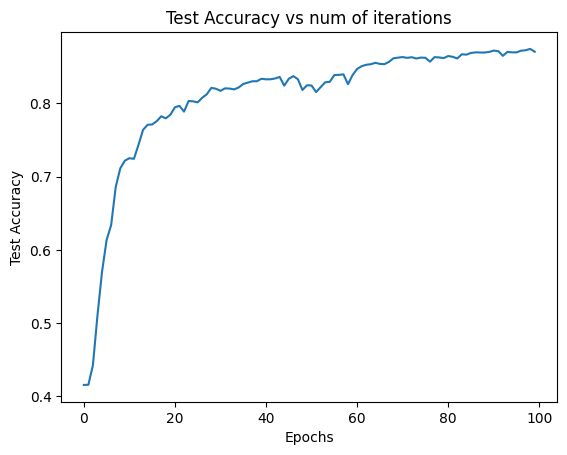

In [ ]:
#Plot graph of training loss vs num of epochs 
plot.plot(epochs, testAccuracies)
plot.xlabel('Epochs')
plot.ylabel('Test Accuracy')
plot.title('Test Accuracy vs num of iterations')
plot.show()

In [ ]:
#Add 1 as a bias term to images
# Xtr = np.concatenate((X_tr, np.ones((X_tr.shape[0], 1))), axis=1)
imageTraining = np.concatenate((imageTraining, np.ones((imageTraining.shape[0], 1))), axis=1)
imageTesting = np.concatenate((imageTesting, np.ones((imageTesting.shape[0], 1))), axis=1)
print(imageTraining.shape, imageTesting.shape)

(60000, 785) (10000, 785)


In [ ]:
# Single layer neural network classifier with loss as quadratic loss

# Define the parameters
batchSize = 10
numOfEpochs = 10
learningRate = 0.01
numOfNeurons = 5

#Initialize the weight matrix - a random and normal gaussian iid
Weights = np.random.normal(0, 1/785, (785, numOfNeurons))
neuralWeights = np.random.normal(0, 1/numOfNeurons, (numOfNeurons, 1))

# To plot
quadLosses = []
testAccuracies = []
trainAccuracies = []

for i in range(numOfEpochs):
    loss = 0.0
    for j in range(0, imageTraining.shape[0], batchSize):
        # Get data of every batch size successively
        images = imageTraining[j:j+batchSize]
        labels = labelsTraining[j:j+batchSize].reshape(-1, 1)

        h = images.dot(Weights)
        hRelu = np.maximum(h, 0)
        predictedLabels = hRelu.dot(neuralWeights)

        # Convert to class 0, 1
        #predictedLabels = np.where(predictedLabels > 0.5, 1, 0)

        quadraticLoss = np.sum((predictedLabels - labels)**2) / batchSize
        loss+= quadraticLoss
        

        #gradients
        gradOut = 2.0 * (predictedLabels - labels) / batchSize
        gradNeuralWeights = hRelu.T.dot(gradOut)
        gradHRelu = gradOut.dot(neuralWeights.T)
        gradH = gradHRelu.copy()
        gradH[h < 0] = 0
        gradWeights = images.T.dot(gradH) / batchSize

        #Update weights
        neuralWeights -= learningRate * gradNeuralWeights
        Weights -= learningRate * gradWeights

        if j % 10000 == 0:
            # Training
            hTraining = imageTraining.dot(Weights)
            hTraingingRelu = np.maximum(0, hTraining)
            predictedTrainingLabels = hTraingingRelu.dot(neuralWeights)
            predictedTrainingLabels = np.where(predictedTrainingLabels > 0.5, 1, 0)
            trainingAccuracy = np.sum(predictedTrainingLabels == labelsTraining.reshape(-1, 1)) / labelsTraining.shape[0]
                
            # Testing
            hTesting = imageTesting.dot(Weights)
            hTestingRelu = np.maximum(0, hTesting)
            predictedTestingLabels = hTestingRelu.dot(neuralWeights)
            predictedTestingLabels = np.where(predictedTestingLabels > 0.5, 1, 0)
            testingAccuracy = np.sum(predictedTestingLabels == labelsTesting.reshape(-1, 1)) / labelsTesting.shape[0] 

            #append to lists to plot graphs
            trainAccuracies.append(trainingAccuracy)
            testAccuracies.append(testingAccuracy)
    quadLosses.append(quadraticLoss)
print('loss:' , quadraticLoss)
print('accuracy:' , testingAccuracy)

loss: 0.012146258416568714
accuracy: 0.9663


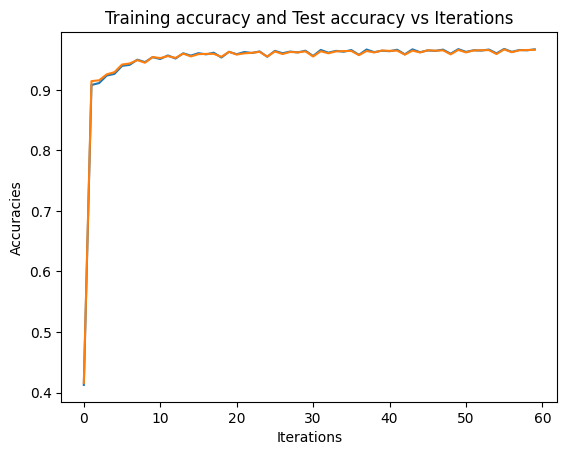

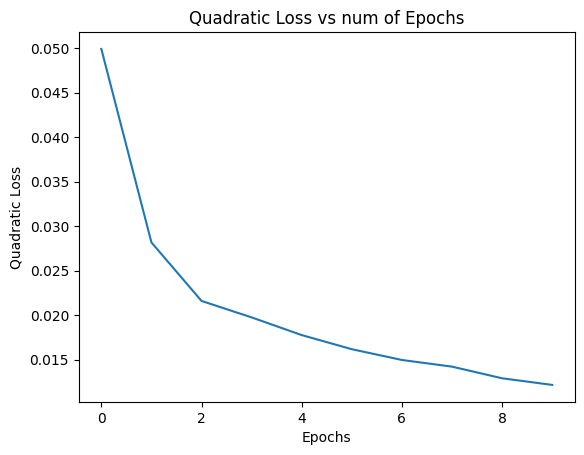

In [ ]:
#Plot graph of training accuracy vs num of epochs 
plot.plot(trainAccuracies, label='train accuracies')
plot.plot(testAccuracies, label='test accuracies')
plot.xlabel('Iterations')
plot.ylabel('Accuracies')
plot.title('Training accuracy and Test accuracy vs Iterations')
plot.show()

#Plot graph of quad losses vs num of epochs 
plot.plot(quadLosses)
plot.xlabel('Epochs')
plot.ylabel('Quadratic Loss')
plot.title('Quadratic Loss vs num of Epochs')
plot.show()

In [ ]:
# Single layer neural network classifier with loss as logistic loss
# It's the same as above except calculation of the loss

# Define the parameters
batchSize = 10
numOfEpochs = 10
learningRate = 0.01
numOfNeurons = 5

#Initialize the weight matrix - a random and normal gaussian iid
Weights = np.random.normal(0, 1/785, (785, numOfNeurons))
neuralWeights = np.random.normal(0, 1/numOfNeurons, (numOfNeurons, 1))

# To plot
logisticLosses = []
testAccuracies = []
trainAccuracies = []

for i in range(numOfEpochs):
    #loss = 0.0
    for j in range(0, imageTraining.shape[0], batchSize):
        # Get data of every batch size successively
        images = imageTraining[j:j+batchSize]
        labels = labelsTraining[j:j+batchSize].reshape(-1, 1)

        h = images.dot(Weights)
        hRelu = np.maximum(h, 0)
        predictedLabels = 1 / (1 + np.exp(-(hRelu.dot(neuralWeights))))
        
        #Calculate the logistic loss
        logisticLoss = -np.mean(labels * np.log(predictedLabels) + (1 - labels) * np.log(1 - predictedLabels))
        #loss += logisticLoss

        #gradients
        gradOut = (predictedLabels - labels) / batchSize
        gradNeuralWeights = hRelu.T.dot(gradOut)
        gradHRelu = gradOut.dot(neuralWeights.T) * (h > 0)
        gradH = gradHRelu.copy()
        gradH[h < 0] = 0
        gradWeights = images.T.dot(gradH) / batchSize

        #Update weights
        neuralWeights -= learningRate * gradNeuralWeights
        Weights -= learningRate * gradWeights
        
        if j % 10000 == 0:
          #Training
          hTraining = imageTraining.dot(Weights)
          hTraingingRelu = np.maximum(0, hTraining)
          predictedTrainingLabels = 1 / (1 + np.exp(-(hTraingingRelu.dot(neuralWeights))))
          predictedTrainingLabels = np.where(predictedTrainingLabels > 0.5, 1, 0)
          trainingAccuracy = np.sum(predictedTrainingLabels == labelsTraining.reshape(-1, 1)) / labelsTraining.shape[0]
          
          # Testing
          hTesting = imageTesting.dot(Weights)
          hTestingRelu = np.maximum(0, hTesting)
          predictedTestingLabels = 1 / (1 + np.exp(-(hTestingRelu.dot(neuralWeights))))
          predictedTestingLabels = np.where(predictedTestingLabels > 0.5, 1, 0)
          testingAccuracy = np.sum(predictedTestingLabels == labelsTesting.reshape(-1, 1)) / labelsTesting.shape[0] 

          #append to lists to plot graphs
          trainAccuracies.append(trainingAccuracy)
          testAccuracies.append(testingAccuracy)
          logisticLosses.append(logisticLoss)
print('loss:' , logisticLoss)
print('accuracy:' , testingAccuracy)

loss: 0.01691045937484161
accuracy: 0.9645


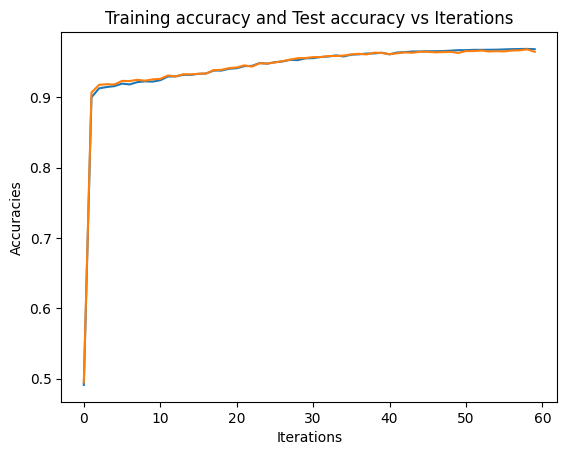

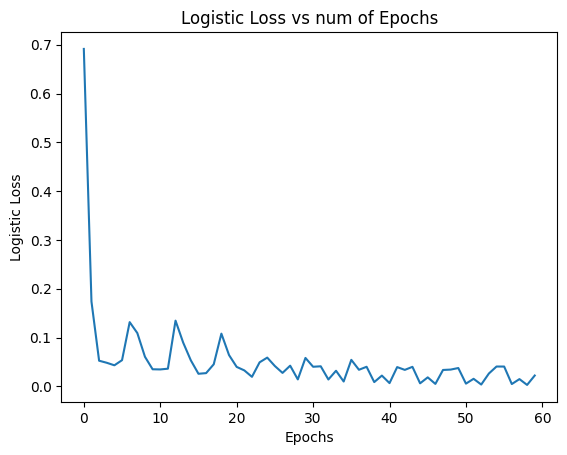

In [ ]:
#Plot graph of training accuracy vs num of epochs 
plot.plot(trainAccuracies, label='train accuracies')
plot.plot(testAccuracies, label='test accuracies')
plot.xlabel('Iterations')
plot.ylabel('Accuracies')
plot.title('Training accuracy and Test accuracy vs Iterations')
plot.show()

#Plot graph of test loss vs num of epochs 
plot.plot(logisticLosses)
plot.xlabel('Epochs')
plot.ylabel('Logistic Loss')
plot.title('Logistic Loss vs num of Epochs')
plot.show()